# Time Series Analysis Models

3 Components of Time Series:
1. ***Trend*** - General movement of the time series (upwards, downwards, horizontal, etc)
2. ***Seasonality*** - Regular ups/downs pattern across time series
3. ***Cyclical*** - Irregular ups/downs across time series

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas.tseries.offsets import DateOffset

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Statsmodel
https://www.statsmodels.org/stable/index.html

In [11]:
df = sm.datasets.macrodata.load_pandas().data
# print(sm.datasets.macrodata.NOTE)
# df.head()

In [12]:
dt_index = pd.Index(sm.tsa.datetools.dates_from_range('1959Q1', '2009Q3'))
df.index = dt_index
df.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
1959-03-31,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1959-06-30,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
1959-09-30,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
1959-12-31,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
1960-03-31,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


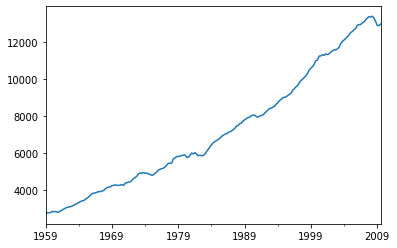

In [9]:
df.realgdp.plot();

### Hodrick-Prescott Filter
Separates ***time series*** data $y_{t}$ into ***trend*** ("stochastic") ${\tau}_{t}$ and ***cyclical*** ("non-stochastic") ${\zeta}_{t}$ components

$y_{t}$ = ${\tau}_{t}$ + ${\zeta}_{t}$

Components ("weights") are "optimized" by minimizing loss function:
$\min_{\\{ \tau_{t}\\} }\sum_{t}^{T}\zeta_{t}^{2}+\lambda\sum_{t=1}^{T}\left[\left(\tau_{t}-\tau_{t-1}\right)-\left(\tau_{t-1}-\tau_{t-2}\right)\right]^{2}$

^*"intuitive"* sense: 
* left term is to minimize noise/cyclical term
* right term is to penalize overfitting to trend term

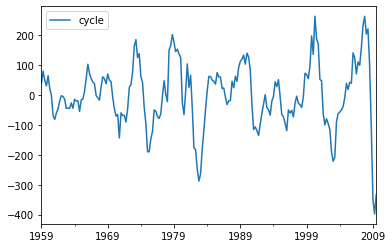

In [21]:
gdp_cycle, gdp_trend = sm.tsa.filters.hpfilter(df['realgdp'])
# df['realgdp'].tail(50).plot(label='realgdp');
# gdp_trend.tail(50).plot(label='trend');
gdp_cycle.plot(label='cycle');
plt.legend();

### EWMA (Exponential Weighted Moving Average)


#### In general:

$ y_{t} = \frac{\sum\limits_{i=0}^{t} w_{i}x_{t-i} }{\sum\limits_{i=0}^{t} w_i} $

#### 3 Ways of Calculating $w_{i}$ (and hence $y_{t}$) using EWMA:
1. If Adjust = False:
    analogous to "*new_pred = coeff * curr_price + (1 - coeff) * prev_pred*"
    
    $ y_{t} = (1 - \alpha) y_{t-1} + \alpha x_{t} $, where $ w_{t} = \begin{cases} \alpha (1 - \alpha)^i & \text{if } i < t \\
    (1 - \alpha)^i & \text{if } i = t \end{cases}$


2. If Adjust = True:

    $ y_{t} = \frac{x_{t} + (1 - \alpha) x_{t-1} + ... + (1 - \alpha)^{t} x_{0}}{1 + (1 - \alpha) + ... + (1 - \alpha)^{t}} $, where $ w_{i} = (1 - \alpha)^{t-i} $
    
#### To calculate $\alpha$:
1. Configure $\alpha$ value directly
2. Use concept of either *span*, *centre of mass* or *half-life*

    $ \alpha = 
        \begin{cases} 
            \frac{2}{s+1} & \text{for span, } s \geq 1 \\
            \frac{1}{1+c} & \text{for centre of mass, } c \geq 0 \\
            1 - exp^{\frac{\log 0.5}{h}} & \text{for half-life, } h \gt 0
    \end{cases} $
    
    *Intuitively*:
    
    * span = last $s$ days to average; the higher $s$ is, the smaller $\alpha$ (and hence relevance of last time-series value) becomes
    
    * centre of mass = mid-pt of last $s$ days to average, since $c=\frac{s-1}{2}$
    
    * half-life = time to decay previous predictions, higher $h$ = lower $\alpha$ (higher relevance of previous predictions, lower relevance of last time-series value)


In [23]:
airline = pd.read_csv('data/airline_passengers.csv', index_col="Month")
airline.dropna(inplace=True)
airline.index = pd.to_datetime(airline.index)
airline.head()

,Thousands of Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


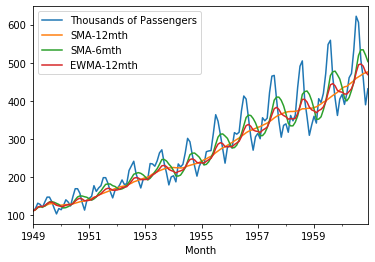

In [31]:
airline['SMA-6mth'] = airline['Thousands of Passengers'].rolling(window=6, min_periods=0).mean()
airline['SMA-12mth'] = airline['Thousands of Passengers'].rolling(window=12, min_periods=0).mean()
airline['EWMA-12mth'] = airline['Thousands of Passengers'].ewm(span=12, min_periods=0).mean()
airline.plot();

### ETS Decomposition
Decomposing time-series into components for prediction/modelling:
1. Error ($E$)
2. Trend ($T$)
3. Seasonality ($S$)

Month
1949-01-01    118.588481
1949-02-01    119.734169
1949-03-01    120.879856
1949-04-01    122.025544
1949-05-01    123.171232
Name: Thousands of Passengers, dtype: float64
Month
1949-01-01    0.911256
1949-02-01    0.890342
1949-03-01    1.012397
1949-04-01    0.980719
1949-05-01    0.979495
Name: Thousands of Passengers, dtype: float64
Month
1949-01-01    1.036418
1949-02-01    1.106896
1949-03-01    1.078621
1949-04-01    1.077940
1949-05-01    1.002938
Name: Thousands of Passengers, dtype: float64


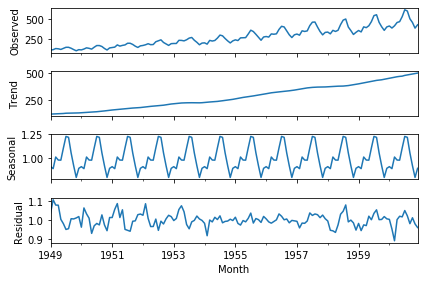

In [44]:
airline_ets = seasonal_decompose(airline['Thousands of Passengers'], model='multiplicative', extrapolate_trend='freq')
print(airline_ets.trend.head())
print(airline_ets.seasonal.head())
print(airline_ets.resid.head())
airline_ets.plot();

### ARIMA (AutoRegressive Integrated Moving Average) Model
* Generalization of AutoRegressive Moving Average (ARMA)
* 2 Types: 1) Non-Seasonal 2) Seasonal

#### Components of ARIMA
1. $p$ : AutoRegression ($AR$) - regression model associating current and previous periods' values
2. $d$ : Integrated ($I$) - differencing of observations (taking difference between previous and current values) in order to make time series stationary
3. $q$ : Moving Average ($MA$) - residual error between values & moving averages applied to lagged (historical) values

#### Concept of *Stationarity*
* Constant mean/var/covar over time - to predict same mean/var/covar for future periods
* Degree of Stationarity tested via **Augmented Dickey-Fuller test (ADF Test)**, which is a hypothesis testing where:
    * $H_{0} = \text{non-stationary time-series}$ (big $p$-value favours this)
    * $H_{1} = \text{stationary time-series}$ (small $p$-value favours this)
* If dataset is not stationary, need to transform via differencing $d$ above
    * akin to doing secondary school quadratic generalization -> take difference in series till the difference values become constant; can also take difference across $x$ (!= 1) shifted periods
    
#### AutoCorrelation / Partial AutoCorrelation Function (ACF/PACF)
* y-axis shows correlation value, x-axis is the number of period lag within the series:

    $ y = corr(p(t), p(t-x)) $ $ \text{, where } y = \text{correlation, } x = \text{# period lag, } p = \text{price time-series function} $
    
#### Usual Steps
* Make time-series stationary - Differencing and doing ADF Test
* Plot ACF/PACF charts
* Construct ARIMA model

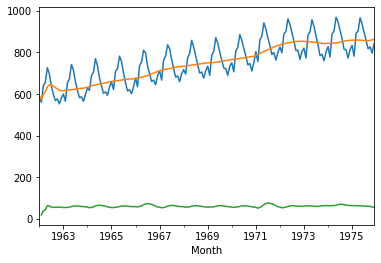

In [32]:
df = pd.read_csv('data/monthly-milk-production-pounds-p.csv')
df.columns = ['Month', 'Pounds Milk Per Cow']
df.drop(168, axis=0, inplace=True)
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df['Pounds Milk Per Cow'].plot();
df['Pounds Milk Per Cow'].rolling(12, min_periods=0).mean().plot();
df['Pounds Milk Per Cow'].rolling(12, min_periods=0).std().plot();

In [33]:
# Augmented Dickey-Fuller Unit Root Test
adf_result = adfuller(df['Pounds Milk Per Cow'].dropna())
# Format of result tuple => 
# adf test statistics (t/z value), p-value, n_lags, n_observations, ...others not impt
adf_result

(-1.3038115874221246,
 0.627426708603034,
 13,
 154,
 {'1%': -3.473542528196209,
  '5%': -2.880497674144038,
  '10%': -2.576878053634677},
 1115.1730447395112)

p-value:  0.03006800400178688


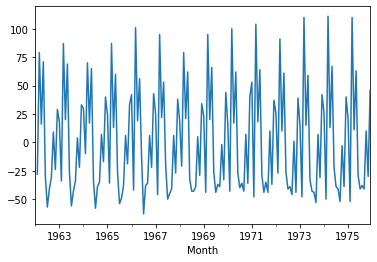

In [37]:
# Differencing
df['Difference 1'] = df['Pounds Milk Per Cow'] - df['Pounds Milk Per Cow'].shift(1)
df['Difference 1'].plot();
adf_result = adfuller(df['Difference 1'].dropna())
print('p-value: ', adf_result[1])

^First Differencing seems to make variance and mean stationary (visual wise & low p-value)
- trying second differencing, and seasonal differencing below to experiment

p-value:  1.1126989332083069e-26


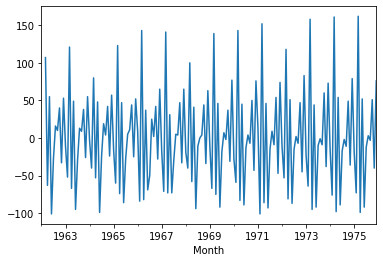

In [38]:
df['Difference 2'] = df['Difference 1'] - df['Difference 1'].shift(1)
df['Difference 2'].plot();
adf_result = adfuller(df['Difference 2'].dropna())
print('p-value: ', adf_result[1])

^p-value suggests even more stationary

p-value:  0.16079880527711304


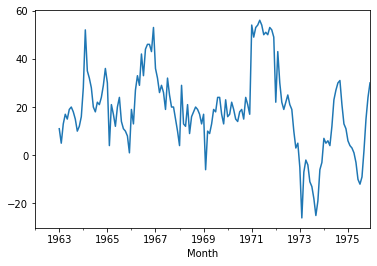

In [40]:
# Seasonal Differencing
df['Seasonal Difference'] = df['Pounds Milk Per Cow'] - df['Pounds Milk Per Cow'].shift(12)
df['Seasonal Difference'].plot();
adf_result = adfuller(df['Seasonal Difference'].dropna())
print('p-value: ', adf_result[1])

^Doesn't look very stationary

p-value:  1.86542343187882e-05


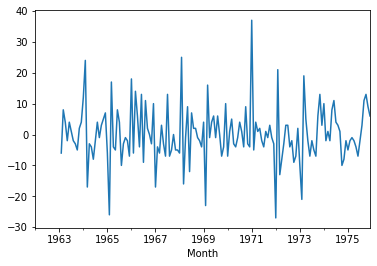

In [41]:
# Seasonal Differencing 1
df['Seasonal Difference 1'] = df['Difference 1'] - df['Difference 1'].shift(12)
df['Seasonal Difference 1'].plot();
adf_result = adfuller(df['Seasonal Difference 1'].dropna())
print('p-value: ', adf_result[1])

^First Seasonal Difference appears more stationary

#### Plotting ACF/PACF

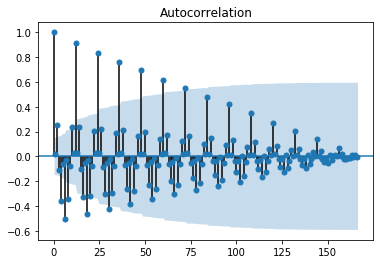

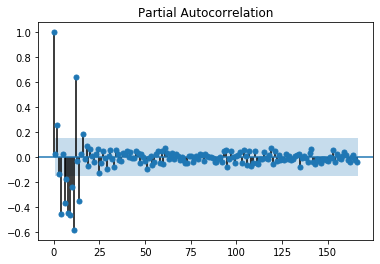

In [71]:
plot_acf(df['Difference 1'].dropna(), lags=(len(df['Difference 1'].dropna()) - 1));
plot_pacf(df['Difference 1'].dropna(), lags=(len(df['Difference 1'].dropna()) - 1), method='ywm');

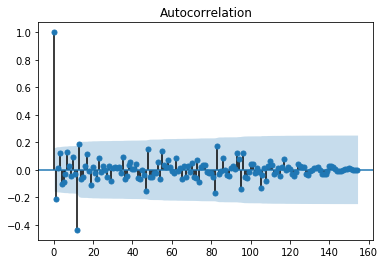

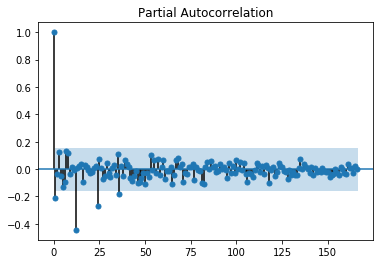

In [72]:
plot_acf(df['Seasonal Difference 1'].dropna(), lags=(len(df['Seasonal Difference 1'].dropna()) - 1));
plot_pacf(df['Seasonal Difference 1'].dropna(), lags=166, method='ywm');

For the above case, since clearer PACF identifiers can be seen for the seasonal difference, usage will be *seasonal, AR*, ARIMA model

In general, for PACF (more strongly used to identify AR use case): 
* if there is a sharp dropoff, AR should be used
* if there is a gradual decline, MA should be used

For $p, d, q$ selection in order/seasonal_order, see:
* https://stats.stackexchange.com/questions/44992/what-are-the-values-p-d-q-in-arima
* https://people.duke.edu/~rnau/arimrule.htm

In [76]:
seasonal_arima_exogenous = SARIMAX(df['Pounds Milk Per Cow'], order=(0, 1, 0), seasonal_order=(1, 1, 1, 12))

C:\Users\tommy.yong\AppData\Local\Continuum\anaconda3\envs\learnenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [77]:
results = seasonal_arima_exogenous.fit()

In [80]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                Pounds Milk Per Cow   No. Observations:                  168
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -534.065
Date:                            Fri, 25 Oct 2019   AIC                           1074.131
Time:                                    09:38:56   BIC                           1083.261
Sample:                                01-01-1962   HQIC                          1077.839
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0449      0.106     -0.422      0.673      -0.253       0.163
ma.S.L12      -0.5860      0.102     -5.762      0.000      -0.785      -0.387
sigma2        55.5118      5.356     10.365      0.000      45.015      66.009
===================================================================================
Ljung-Box (Q):                       33.48   Jarque-Bera (JB):                32.04
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             0.77
Prob(H) (two-sided):                  0.18   Kurtosis:                         4.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

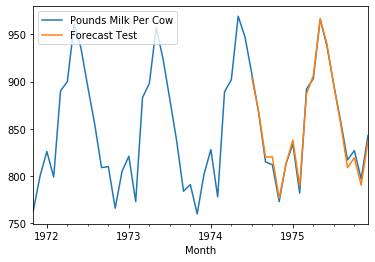

In [87]:
df['Forecast Test'] = results.predict(start=150, end=168)
df[['Pounds Milk Per Cow', 'Forecast Test']].tail(50).plot();

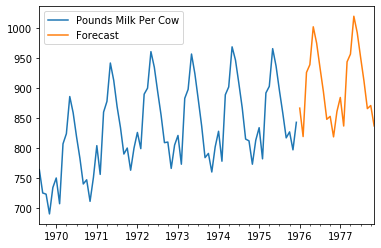

In [103]:
# Future Forecast, to add empty rows indexes first, using pandas DateOffset
future_dates_indexes = [df.index[-1] + DateOffset(months=x) for x in range(1, 24)]
future_df = pd.DataFrame(index=future_dates_indexes, columns=df.columns)
future_df = pd.concat([df, future_df])
future_df['Forecast'] = results.predict(start=168, end=192)
future_df[['Pounds Milk Per Cow', 'Forecast']].tail(100).plot();

## Limitations of Time Series Models
* Only takes into account that price = function(time)
* However, financial prices affected by other non-time factors (e.g. other traders' speculations, etc)
* Better represented with *Brownian Motion*, *Monte Carlo Simulations*, etc